In [ ]:
# models output : [buy, hold, sell]

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras import models, layers, optimizers
from keras.losses import huber_loss
from keras.regularizers import L1L2

from collections import deque

import gc


Using TensorFlow backend.


In [2]:
class QNetwork:
    def __init__(self, input_size):
        self.model = make_models(input_size)


In [3]:
def make_models(input_size, output_size=1, n_layers=3):
    inputs = layers.Input(shape=(input_size, ))
    x = layers.Dense(64, activation='relu', kernel_regularizer = L1L2(l2= 0.001), kernel_initializer='he_normal')(inputs)

    for i in range(n_layers-1):
        x = layers.Dense(32//(2**(i+1)), kernel_regularizer=L1L2(l2= 0.001), kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)

    outputs = layers.Dense(output_size, activation='sigmoid')(x)

    m = models.Model(inputs, outputs)

    
    # AE weight initializer
#     encoder_inputs = layers.Input((18, ))
#     x = layers.Dense(16, activation='relu', kernel_regularizer=L1L2(l2 = 0.01))(encoder_inputs)
#     outputs = layers.Dense(18, activation='linear')(x)

#     model = models.Model(encoder_inputs, outputs)
#     encoder = models.Model(encoder_inputs, x)

#     model.compile(optimizer = 'adam',
#                  loss = 'mse')
    
#     model.fit(state, state, epochs=30, verbose=0)
    
#     encoder.layers[1].set_weights(model.layers[1].get_weights())
#     m.layers[1].set_weights(model.layers[1].get_weights())
    
#     new = encoder.predict(state)
#     del encoder_inputs, x, outputs, encoder, model
#     encoder_inputs = layers.Input((16, ))
#     x = layers.Dense(8, activation='relu', kernel_regularizer=L1L2(l2 = 0.01))(encoder_inputs)
#     outputs = layers.Dense(16, activation='linear')(x)

#     model = models.Model(encoder_inputs, outputs)

#     model.compile(optimizer = 'adam',
#                  loss = 'mse')

#     model.fit(new, new, epochs=30, verbose=0)

#     m.layers[2].set_weights(model.layers[1].get_weights())
#     del model, encoder_inputs, outputs, x
    
    m.compile(optimizer = optimizers.Adam(lr=1e-4),
             loss = huber_loss)

    return m

In [4]:
class Memory:
    def __init__(self):
        self.buffer = deque(maxlen=memory_size)
        
    def add(self, exp):
        self.buffer.append(exp)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]
    
    def __len__(self):
        return len(self.buffer)
    
    

In [5]:
data = pd.read_csv('./data/stock.csv', thousands=',')
d = data.drop(['date', 'close', 'high', 'low'], axis=1)
d.columns

moving = pd.Series()
for cat in d.columns:
    for i in (5, 10, 30, 60):
        moving = pd.concat([moving, d[cat].rolling(i).mean()], axis=1)
        
moving.columns = ['0', 'moving_p5','moving_p10','moving_p30','moving_p60',
                  'moving_vol5','moving_vol10','moving_vol30','moving_vol60',
                  'moving_per5','moving_per10','moving_per30','moving_per60',
                  'moving_pbr5','moving_pbr10','moving_pbr30','moving_pbr60']

moving = moving.drop('0', axis=1)
moving = pd.concat([moving, data.high, data.low], axis=1)

X = moving[61:]
y = data.open[61:]

X = (X - np.min(X))/(np.max(X) - np.min(X))
# y = (y - np.min(y))/(np.max(y) - np.min(y))

state = X.values.copy()
p = y.values.copy()
# p = y.values.copy()
# p += 1e-5

In [30]:
# not reward clipped version
class Agent:
    def __init__(self, balance, n_stocks, state):
        self.fs = [balance, n_stocks] # [cash, n_stock]
        self.balance = self.update_balance(self.fs, p[0])
        self.state = state
        self.main = make_models(18)
        self.learner = make_models(18)
        
        
    def train(self, n_steps):
        success_count = 0
        for n in range(n_steps):
#             if success_count >= 5:
#                 break
            fs = [BALANCE, 0]
            balance = BALANCE
            step = 0
            steps = len(self.state)
            for i in range(0, steps-2):
                step += 1
                eps = 0.01 + (EPS - 0.01) * np.exp(-DECAY * step)

                self.learner.set_weights(self.main.get_weights())

                # action 
                if eps > np.random.rand():
                    action = np.random.choice([0, 1])
                else:
                    action = self.make_decision(self.main.predict(state[i:i+1])[0][0])

                # current stock price
                price = p[i]
                # update fs
                fs = self.update_fs(fs, action, price)
                # update balance and make reward
                new_balance = self.update_balance(fs, price)

                reward = ((new_balance / balance) - 1)
                if reward > 0:
                    reward = 1
                else:
                    reward = 0
#                 print(reward)

                balance = new_balance

                # memorize
                if step > WARMUP:
                    memory.add((state[i:i+1], action, reward, state[i+1:i+2]))

                # learner update
            for _ in range(10):

                np.random.seed(_)
                inputs = np.zeros((BATCH_SIZE, 18))
                targets = np.zeros((BATCH_SIZE, 1))

                minibatch = memory.sample(BATCH_SIZE)

                for j, (s, a, r, ss) in enumerate(minibatch):
                    inputs[j] = s
                    if not (ss == np.zeros(s.shape)).all(axis=1):
                        target = r + GAMMA * self.learner.predict(ss)[0][0]
                    else:
                        target = r
                        
                    targets[j] = target
                
#                     targets[j][a] = target

                self.main.fit(inputs, targets, epochs=1, verbose=0)
#                 print(i)


            # as episode end
                hist = self.simulation()
                hist = np.array(hist) - self.balance
                plt.axhline(y=0, color='r', linestyle='-')
                plt.plot(hist)
                plt.show()
                print((_+1), 'steps','mean gain:', round(np.mean(hist)/BALANCE, 3))
#                 if np.mean(hist)/BALANCE == 0:
#                     self.main = make_models(18)
                    
#                 if hist[-1] / BALANCE > 1:
#                     success_count += 1
#                 else:
#                     success_count = 0
                    
#                 if success_count >= 5:
#                     break
                    
            
        return fs, balance
            
    def update_fs(self, fs, action, price):
        if action == 1: # buy
            n = fs[0] // price
            b = fs[0] % price
            new_n = fs[1]+ n
            return [b, new_n]
        
#         elif action == 1: # hold
#             return self.fs
        
        else: # sell
            b = fs[1] * price
            new_b = fs[0]+b
            return [new_b, 0]
        
    
    def update_balance(self, fs, price):
        b = fs[0] + fs[1] * price
#         print(b, self.fs)
        return b
        
    def simulation(self, debug=False):
        fs = [BALANCE, 0]
        balance = BALANCE
        hist = []
        sales = [0, 0]
        for i in range(len(state)-1):
            a = self.make_decision(self.main.predict(self.state[i:i+1])[0][0])
            price = p[i]
            fs = self.update_fs(fs, a, price)
            balance = self.update_balance(fs, price)
            hist.append(balance)
            sales[a] += 1
            if debug:
                print(sales, balance)
        print(sales)
        return hist
    
    def clipping(self, r):
        if r > 0: return 1
        elif r < 0 : return -1
        else: return 0
        
    def make_target(self, action, target):
        if action == 0 : 
            return [max(target, 0), max(-target, 0)]
        else:
            return [max(-target, 0), max(target, 0)]
        
    def make_decision(self, a):
        if a>=0.5: return 1
        else: return 0

In [31]:
K.clear_session()

GAMMA = 0.99
WARMUP = 0
N_EPISODES = 1000
EPS = 0.1
DECAY = 0.001

memory_size = 1000
BATCH_SIZE = 512

BALANCE = 10000000

memory = Memory()
a = Agent(BALANCE, 30, state)
gc.collect()

197238

[166, 3073]


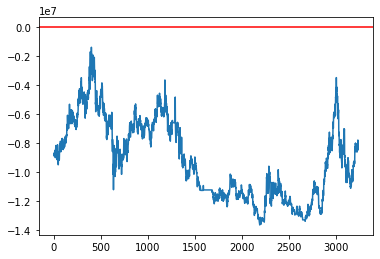

1 steps mean gain: -0.914
[807, 2432]


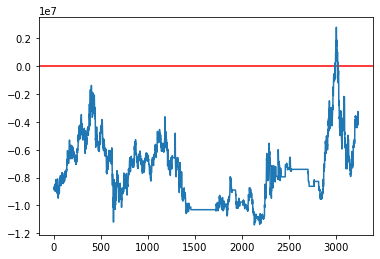

2 steps mean gain: -0.752
[1132, 2107]


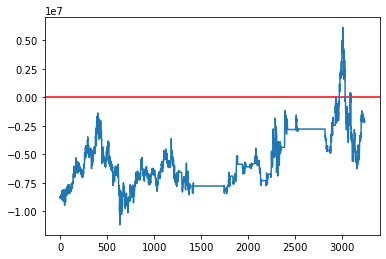

3 steps mean gain: -0.557
[1483, 1756]


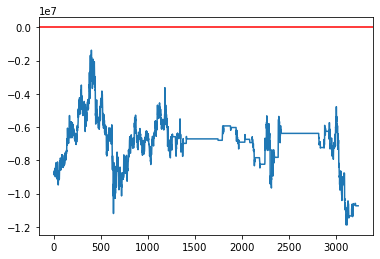

4 steps mean gain: -0.692
[1676, 1563]


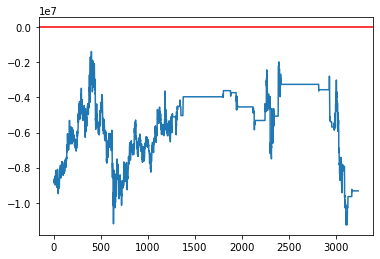

5 steps mean gain: -0.536
[1757, 1482]


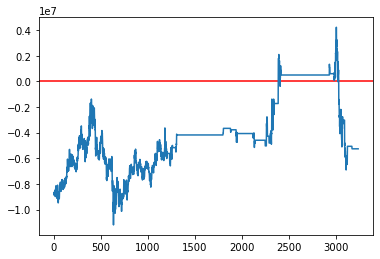

6 steps mean gain: -0.413
[1796, 1443]


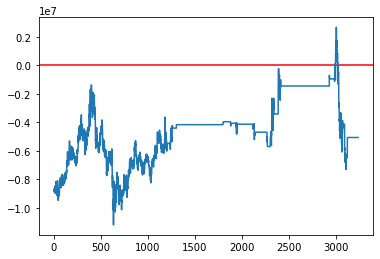

7 steps mean gain: -0.457
[1802, 1437]


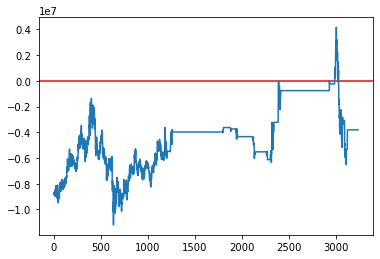

8 steps mean gain: -0.436
[1809, 1430]


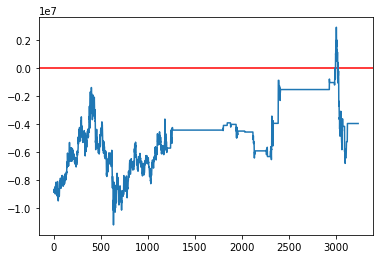

9 steps mean gain: -0.468
[1814, 1425]


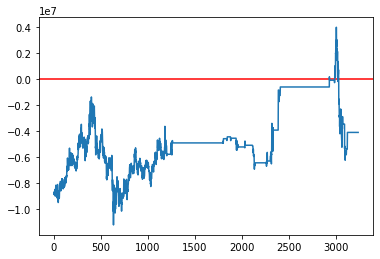

10 steps mean gain: -0.465


In [ ]:
%%time
a.train(10)

In [ ]:
gc.collect()

In [ ]:
a.main.predict(state)

In [ ]:
hist = a.simulation(debug=True)

In [7]:
m = make_models(18)

In [9]:
m.predict(state[1:2])[0][0]

0.5188218